# Analyze dataframes

for all csv-files:
    load dataframe
    find period where only one contender is active

In [198]:
# start by defining a Project name
project = 'medicin_prices'
import os # generel package for interacting with the system
# among other things automate folder creation
def maybe_create_dir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

maybe_create_dir(project)

subfolders = ['raw_data','parsed_data']

raw_data = os.path.join(project, subfolders[0])
# Special folder that is write protected in order to preserve the original data
raw_data_read_only = os.path.join(project, subfolders[0] + '-read-only')
parsed_data = os.path.join(project, subfolders[1])

for directory in subfolders: 
    maybe_create_dir(os.path.join(project, directory))

In [199]:
# Get all csv files
import glob

csv_files = glob.glob(os.path.join(raw_data_read_only, '*.csv'))

In [200]:
print(csv_files[:10])

['medicin_prices/raw_data-read-only/076043.csv', 'medicin_prices/raw_data-read-only/070380.csv', 'medicin_prices/raw_data-read-only/527140.csv', 'medicin_prices/raw_data-read-only/373077.csv', 'medicin_prices/raw_data-read-only/147370.csv', 'medicin_prices/raw_data-read-only/075494.csv', 'medicin_prices/raw_data-read-only/536076.csv', 'medicin_prices/raw_data-read-only/518668.csv', 'medicin_prices/raw_data-read-only/088392.csv', 'medicin_prices/raw_data-read-only/057927.csv']


In [201]:
# This looks interesting, we have a price spike of 460% in the beginning of 2018
# ramipril_10mg_100stk = '138091'
# csv_file = ramipril_10mg_100stk + '.csv'

In [202]:
import pandas as pd

# This looks interesting, we have a price spike of 460% in the beginning of 2018
ramipril_10mg_100stk_df = pd.read_csv(os.path.join(raw_data_read_only, '138091.csv'))
lansoprazol_30mg_28stk_df = pd.read_csv(os.path.join(raw_data_read_only, '164584.csv'))
# losartanka_ = pd.read_csv(os.path.join(raw_data_read_only, '189624.csv'))
costad_20p5mgml_3x5ml = pd.read_csv(os.path.join(raw_data_read_only, '594005.csv'))

# Losartanka 189624 - 100+12,5 mg - 28 stk

# Costad 594005 - 20+5 mg/ml - 3 x 5 ml


In [203]:
ramipril_10mg_100stk_df.head()

,Unnamed: 0,datetime,tilskudspris,138091,377587,483121,490176,503096
0,251,16.07.2007,1.12,NaN,NaN,NaN,NaN,NaN
1,252,30.07.2007,1.01,NaN,NaN,NaN,NaN,NaN
2,253,13.08.2007,0.90,NaN,NaN,NaN,NaN,NaN
3,254,27.08.2007,0.86,NaN,NaN,NaN,NaN,NaN
4,255,10.09.2007,0.82,NaN,NaN,NaN,NaN,NaN


In [204]:
# Drop random unnamed column
ramipril_10mg_100stk_df = ramipril_10mg_100stk_df.drop('Unnamed: 0', axis=1)

In [205]:
# Convert datetime column to an actual date and set it as index
ramipril_10mg_100stk_df['datetime'] = pd.to_datetime(ramipril_10mg_100stk_df['datetime'], format='%d.%m.%Y')
ramipril_10mg_100stk_df = ramipril_10mg_100stk_df.set_index('datetime')

In [206]:
ramipril_10mg_100stk_df.tail()

,tilskudspris,138091,377587,483121,490176,503096
datetime,,,,,,
2019-06-17,2.01,2.12,NaN,2.18,NaN,2.01
2019-07-01,1.37,1.40,NaN,1.37,NaN,1.51
2019-07-15,1.04,1.13,1.09,1.04,NaN,1.06
2019-07-29,0.63,1.13,0.63,0.87,0.77,0.67
2019-08-12,0.49,1.13,0.63,0.87,0.49,0.49


In [207]:
# Drop the column 'tilskudspris' as it is not pertinent to the current test
ramipril_10mg_100stk_df = ramipril_10mg_100stk_df.drop('tilskudspris', axis=1)
# Remove rows without any values in them
ramipril_10mg_100stk_df = ramipril_10mg_100stk_df.dropna(thresh=1)

In [208]:
cleaned_test.head()

,138091,377587,483121,490176,503096
datetime,,,,,
2011-04-18,NaN,NaN,NaN,NaN,1.13
2011-05-02,NaN,NaN,NaN,NaN,1.03
2011-05-16,NaN,NaN,NaN,NaN,0.95
2011-05-30,NaN,NaN,NaN,NaN,0.90
2011-06-13,NaN,NaN,NaN,NaN,0.90


In [111]:
limited_period = cleaned_test.loc['2018-01-15':'2019-01-01']

In [123]:
limited_period.head()

,tilskudspris,138091,377587,483121,490176,503096
datetime,,,,,,
2018-01-15,0.34,NaN,NaN,0.34,0.36,0.41
2018-01-29,0.36,NaN,NaN,0.36,0.36,0.41
2018-02-12,0.35,0.36,NaN,0.41,0.35,0.36
2018-02-26,0.34,0.34,NaN,0.41,0.51,0.41
2018-03-12,0.41,NaN,NaN,0.41,0.51,0.60


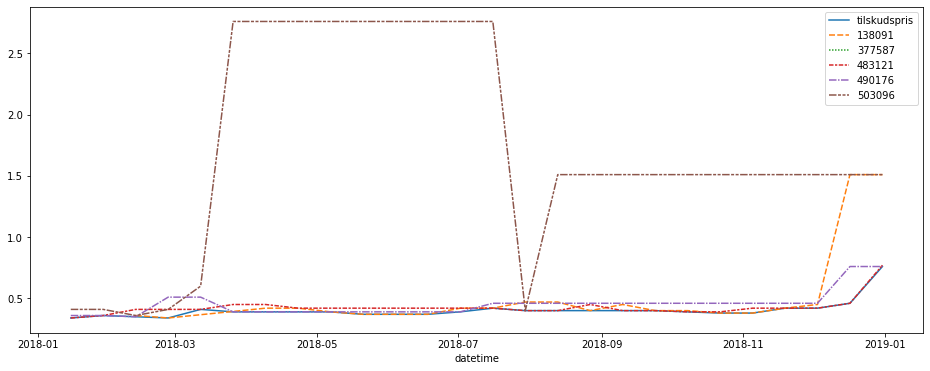

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(16,6))
sns.lineplot(data=limited_period)


In [113]:
diff = limited_period['503096'] / limited_period['503096'].shift(-1)

In [155]:
def compute_shifted_difference(df, period=1):
    return (df / df.shift(period)).copy()

In [154]:
plt.figure(figsize=(16,6))
sns.lineplot(data=compute_shifted_difference(limited_period['503096'], 1))

AttributeError: 'Series' object has no attribute 'columns'

<Figure size 1152x432 with 0 Axes>

In [116]:
diff2 = compute_shifted_difference(limited_period['503096'], 2)

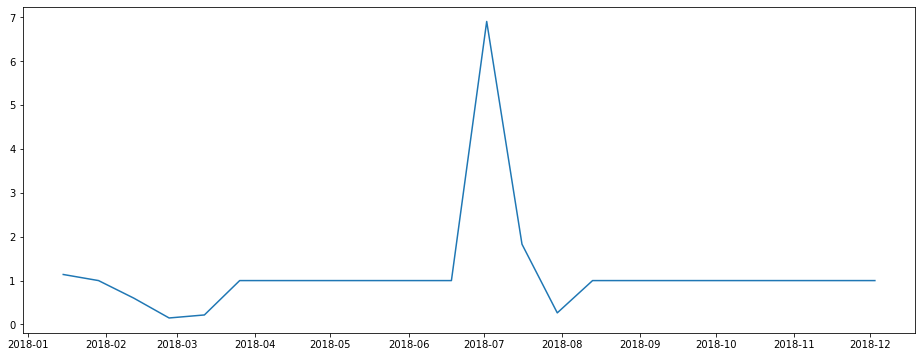

In [136]:
plt.figure(figsize=(16,6))
sns.lineplot(data=diff2)

In [137]:
list(range(1,7))

[1, 2, 3, 4, 5, 6]

In [138]:
div_shift = [compute_shifted_difference(limited_period['503096'], i) for i in range(1,7)]

In [139]:
len(div_shift)

6

In [140]:
limited_period

,tilskudspris,138091,377587,483121,490176,503096
datetime,,,,,,
2018-01-15,0.34,NaN,NaN,0.34,0.36,0.41
2018-01-29,0.36,NaN,NaN,0.36,0.36,0.41
2018-02-12,0.35,0.36,NaN,0.41,0.35,0.36
2018-02-26,0.34,0.34,NaN,0.41,0.51,0.41
2018-03-12,0.41,NaN,NaN,0.41,0.51,0.60
2018-03-26,0.39,NaN,NaN,0.45,0.39,2.76
2018-04-09,0.39,0.42,NaN,0.45,0.39,2.76
2018-04-23,0.39,0.42,NaN,0.42,0.39,2.76
2018-05-07,0.39,0.39,NaN,0.42,0.39,2.76


In [146]:
more_limited_period = cleaned_test.loc['2018-01-29':'2018-04-24']
more_limited_period

,tilskudspris,138091,377587,483121,490176,503096
datetime,,,,,,
2018-01-29,0.36,NaN,NaN,0.36,0.36,0.41
2018-02-12,0.35,0.36,NaN,0.41,0.35,0.36
2018-02-26,0.34,0.34,NaN,0.41,0.51,0.41
2018-03-12,0.41,NaN,NaN,0.41,0.51,0.60
2018-03-26,0.39,NaN,NaN,0.45,0.39,2.76
2018-04-09,0.39,0.42,NaN,0.45,0.39,2.76
2018-04-23,0.39,0.42,NaN,0.42,0.39,2.76


In [147]:
test = compute_shifted_difference(more_limited_period['503096'], 1)

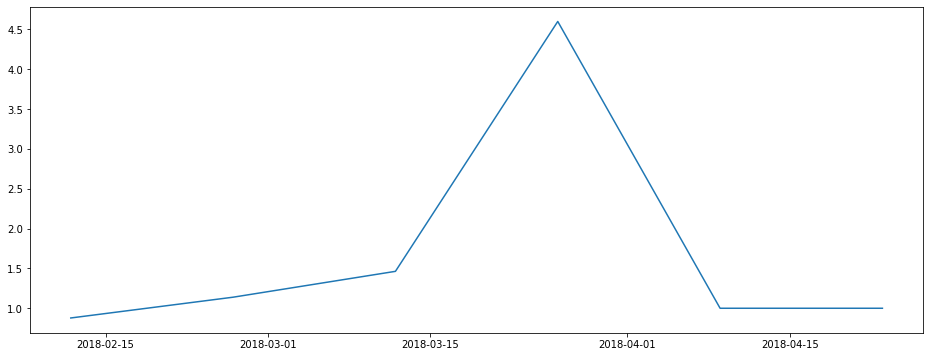

In [148]:
plt.figure(figsize=(16,6))
sns.lineplot(data=test)

In [152]:
test.head()

datetime
2018-01-29         NaN
2018-02-12    0.878049
2018-02-26    1.138889
2018-03-12    1.463415
2018-03-26    4.600000
Name: 503096, dtype: float64

In [149]:
test2 = compute_shifted_difference(more_limited_period['503096'], 2)

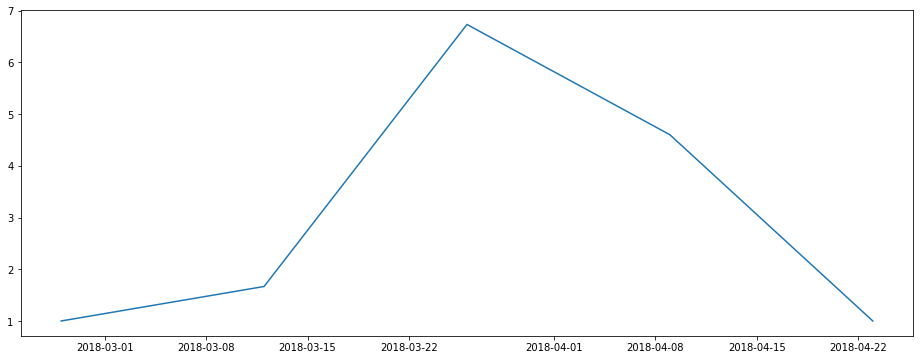

In [150]:
plt.figure(figsize=(16,6))
sns.lineplot(data=test2)

In [151]:
test2.head()

datetime
2018-01-29         NaN
2018-02-12         NaN
2018-02-26    1.000000
2018-03-12    1.666667
2018-03-26    6.731707
Name: 503096, dtype: float64

In [158]:
limited_period.pct_change(2)

,tilskudspris,138091,377587,483121,490176,503096
datetime,,,,,,
2018-01-15,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-12,0.029412,NaN,NaN,0.205882,-0.027778,-0.121951
2018-02-26,-0.055556,NaN,NaN,0.138889,0.416667,0.000000
2018-03-12,0.171429,-0.055556,NaN,0.000000,0.457143,0.666667
2018-03-26,0.147059,0.000000,NaN,0.097561,-0.235294,5.731707
2018-04-09,-0.048780,0.235294,NaN,0.097561,-0.235294,3.600000
2018-04-23,0.000000,0.235294,NaN,-0.066667,0.000000,0.000000
2018-05-07,0.000000,-0.071429,NaN,-0.066667,0.000000,0.000000


In [ ]:
def find_increase(df, min_increase=1.5):
    
    

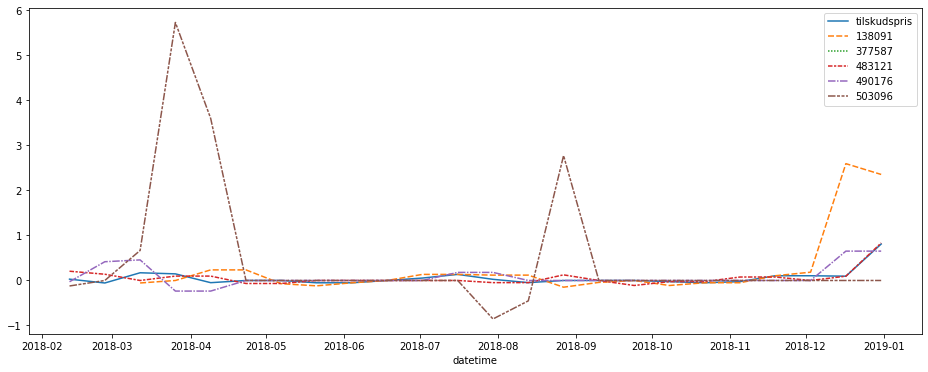

In [161]:
plt.figure(figsize=(16,6))
sns.lineplot(data=limited_period.pct_change(2))

In [166]:
list(range(1,7))

[1, 2, 3, 4, 5, 6]

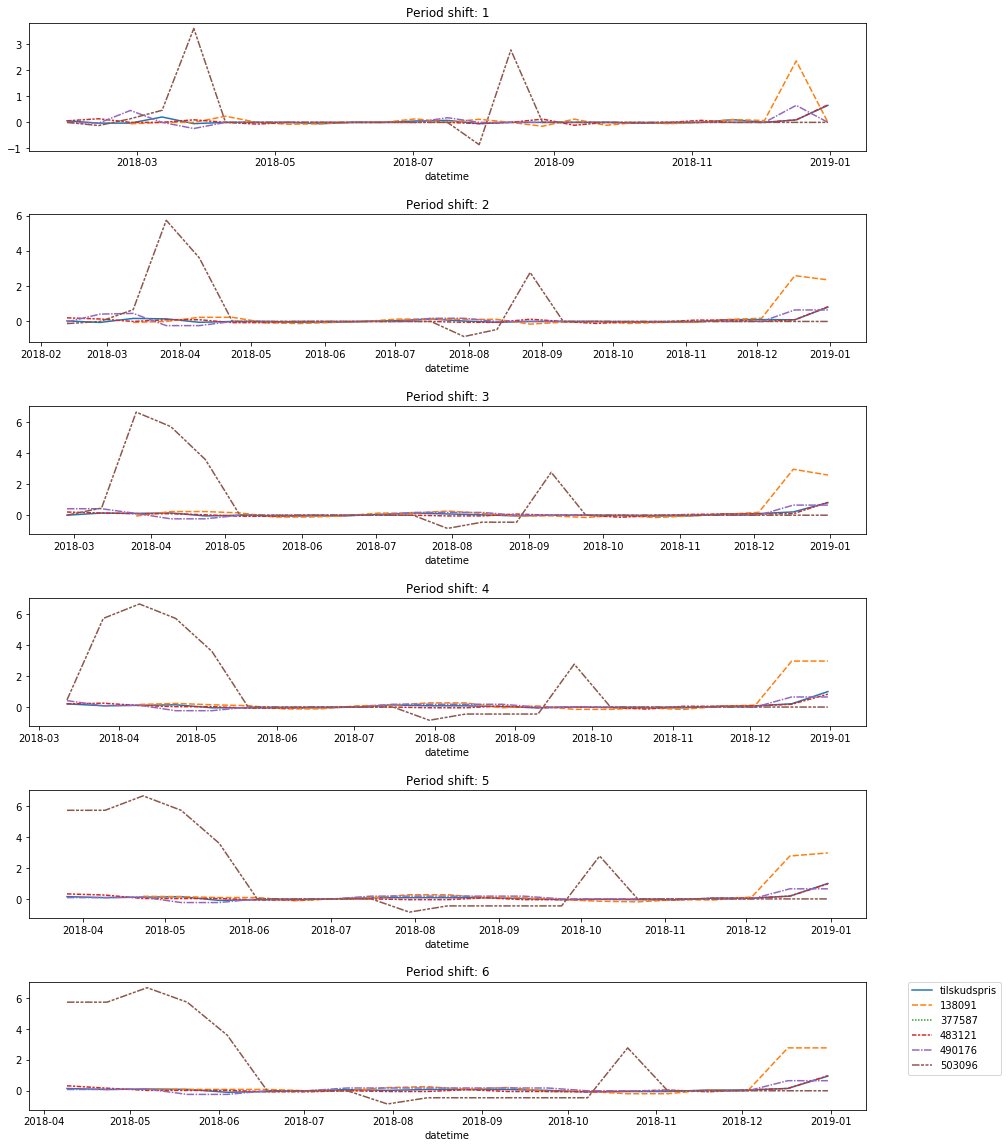

In [185]:
# fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig, axs = plt.subplots(6,1, figsize=(15, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

period_shift = 7

data_src = [limited_period.pct_change(i) for i in range(1,period_shift)]
axs = axs.ravel()

for i in range(period_shift-1):
    
    g = sns.lineplot(data=data_src[i], ax=axs[i])
#     axs[i].set_title("Period shift: " + str(i+1))
    g.set_title("Period shift: " + str(i+1))
#     g.set_xticklabels(rotation=30)
    axs[i].legend().remove()
    
#     axs[i].contourf(np.random.rand(10,10),5,cmap=plt.cm.Oranges)
#     axs[i].set_title(str(250+i))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

7


<Figure size 1152x432 with 0 Axes>

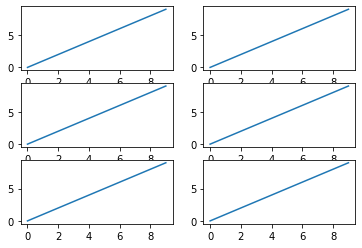

In [165]:
x = range(10)
y = range(10)

data_src = [limited_period]

data_src = data_src + [limited_period.pct_change(i) for i in range(1,7)]

print(len(data_src))

plt.figure(figsize=(16,6))
fig, ax = plt.subplots(nrows=3, ncols=2)

for row in ax:
    for col in row:
        sns.lineplot(data=)
        col.plot(x, y)

plt.show()

In [ ]:
fig, ax = plt.subplots()
# ax.plot(x, y)
# ax.set_title('Simple plot')

# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)